## Part 1: Over-representation and Enrichment Analysis

In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import urllib
import urllib as ul
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import networkx as nx
import ast
from prettytable import PrettyTable
import gseapy as gp
from palettable import wesanderson

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.getcwd())

/Users/chaeeunlee/Documents/VSC_workspaces/ISMB_Test/Section2


### 0. Load networks built in Section 1

- Gene correlation network
- Patient network from TCGA gene expression data
- Patient network from TCGA DNA methylation data


In [3]:
# Define paths to .gml network files from Section 1
# These paths point to the Gene correlation network, Patient network from (1) TCGA gene expression data and (2) TCGA DNA methylation data.
G_patient_gxp_path = 'section2_data/section2_networks_v2/patient_coexpression_network_knn.gml'
G_patient_dnam_path = 'section2_data/section2_networks_v2/patient_meth_network_knn.gml'
G_gxp_path = 'section2_data/section2_networks_v1/gene_coexpression_network.gml'

# Load the GML graphs into NetworkX graph objects
# nx.read_gml() function reads a graph from a GML file
G_gxp = nx.read_gml(G_gxp_path)  # Gene correlation network
G_patient_gxp = nx.read_gml(G_patient_gxp_path)  # Patient gene expression network
G_patient_dnam = nx.read_gml(G_patient_dnam_path)  # Patient methylation network

# Get all nodes in each graph
# The nodes represent genes or patients depending on the network
G_gxp_nodes_list = list(G_gxp.nodes())  # Nodes in the gene correlation network
G_patient_gxp_nodes_list = list(G_patient_gxp.nodes())  # Patient nodes
G_patient_dnam_nodes_list = list(G_patient_dnam.nodes())  # Patient nodes

# Define paths to the raw TCGA datasets
tcga_dnam_path = 'section2_data/ISMB_TCGA_DNAm.pkl'  # TCGA DNA methylation data
tcga_gxp_path = 'section2_data/ISMB_TCGA_GE.pkl'  # TCGA Gene expression data

# Load the gene expression dataset
# pd.read_pickle() function loads a pickled pandas DataFrame or Series
tcga_gxp = pd.read_pickle(tcga_gxp_path)

# For this example, we'll use a CSV file that includes gene symbols
# pd.read_csv() function loads a CSV file into a pandas DataFrame
tcga_gxp_df = pd.read_csv('section2_data/tcga_ge_df_symbols_t.csv')  # Dataset with gene symbols
# Set 'GENES' column as the index for easy access to gene-specific data
tcga_gxp_df.set_index('GENES', inplace=True)

# Extract metadata from the gene expression dataset
# Metadata might include information such as patient IDs, sample conditions, etc.
tcga_gxp_meta = tcga_gxp['datMeta']

# Print the number of nodes in each network
# This provides a quick overview of the size of each network
print(f"Number of nodes in gene correlation network: {len(G_gxp_nodes_list)}")
print(f"Number of nodes in patient gene expression network: {len(G_patient_gxp_nodes_list)}")
print(f"Number of nodes in patient DNA methylation network: {len(G_patient_dnam_nodes_list)}")


Number of nodes in gene correlation network: 300
Number of nodes in patient gene expression network: 434
Number of nodes in patient DNA methylation network: 381


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def draw_network_with_node_attrs(G, node_attributes, communities=None, title='Network Visualization', color_attr=None, shape_attr=None, figsize=(20,10), layout='spring', cmap_name='tab20', with_labels=False):
    """
    Draws a graph with nodes colored by their community memberships and includes a legend indicating the community index.
    Nodes can also be colored and shaped based on additional attributes.

    Args:
        G (networkx.Graph): The graph to be drawn.
        communities (list of lists): A list where each sublist contains the nodes belonging to a community.
        node_attributes (dict): A dictionary where keys are node names and values are dictionaries of attributes.
        color_attr (str, optional): Node attribute to color by.
        shape_attr (str, optional): Node attribute to shape by.
        figsize (tuple, optional): The size of the figure. Default is (10, 10).
        layout (str, optional): The layout algorithm for positioning nodes (e.g., 'spring', 'circular'). Default is 'spring'.
        cmap_name (str, optional): The name of the colormap to use for coloring communities. Default is 'tab20'.

    Raises:
        ValueError: If the graph G is empty or not defined.
        ValueError: If the communities list is empty or not defined.
        ValueError: If node_attributes is empty or not defined.
    """
    if not G:
        raise ValueError("The graph is empty or not defined.")
    if not node_attributes:
        raise ValueError("Node attributes are empty or not defined.")

    if communities:
        community_dict = {node: idx for idx, community in enumerate(communities) for node in community}
        node_attributes['community']=community_dict
    print(f"node_attributes: {node_attributes}")
    
    shapes = ['o', '^', 's', 'p', 'h', 'H', '8', 'd', 'D', 'v', '<', '>', 'P', '*', 'X']
    cmap = plt.get_cmap(cmap_name)
    
    unique_attr_vals_color = list(set(node_attributes[color_attr].values())) if color_attr else []
    color_map = {val: cmap(i / len(unique_attr_vals_color)) for i, val in enumerate(unique_attr_vals_color)}
    
    node_colors_from_attribute = [color_map[node_attributes[color_attr][node]] for node in G.nodes()] if color_attr else ['blue']*len(list(G.nodes()))
    
    unique_attr_vals_shape = list(set(node_attributes[shape_attr].values())) if shape_attr else []
    shape_map = {val: shapes[i] for i, val in enumerate(unique_attr_vals_shape)}
    node_shapes_from_attribute = [shape_map[node_attributes[shape_attr][node]] if shape_attr else 'o' for node in G.nodes()]

    plt.figure(figsize=figsize)
    pos = getattr(nx, f'{layout}_layout')(G) if hasattr(nx, f'{layout}_layout') else nx.spring_layout(G)
    
    node_list_by_shape = {}
    node_idx_list_by_shape = {}
    for shape_marker in shapes[:len(unique_attr_vals_shape)]:
        node_list_by_shape[shape_marker] = [node for node in list(G.nodes()) if shape_map[node_attributes[shape_attr][node]] == shape_marker]
        node_idx_list_by_shape[shape_marker] = [node_idx for node_idx, node in enumerate(list(G.nodes())) if shape_map[node_attributes[shape_attr][node]] == shape_marker]
    
    for shape_marker, node_list in node_list_by_shape.items():
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=node_list_by_shape[shape_marker],
            node_color=[node_colors_from_attribute[i] for i in node_idx_list_by_shape[shape_marker]],
            node_shape=shape_marker,
            node_size=400,
            edgecolors='yellow'
        )

    nx.draw_networkx_edges(G, pos, width=0.5)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=12)

    legend_fontsize = 14
    # leg1=None
    if shape_attr:
        shape_legend_handles = [Line2D([0], [0], marker=shape_map[val], color='w', label=f'{val}', markerfacecolor='k', markersize=10) for val in unique_attr_vals_shape]
        leg1 = plt.legend(handles=shape_legend_handles, title=f"{shape_attr.capitalize()} (Shape)", loc='upper left', bbox_to_anchor=(1, 0.5), fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    if color_attr:
        color_legend_handles = [Patch(facecolor=color_map[val], label=f'{color_attr} {val}') for val in unique_attr_vals_color]
        leg2 = plt.legend(handles=color_legend_handles, title=f"{color_attr.capitalize()} (Color)", loc='upper left', bbox_to_anchor=(1, 1), fontsize=legend_fontsize, title_fontsize=legend_fontsize)
    if shape_attr:
        plt.gca().add_artist(leg1)
    plt.title(title, fontsize=20)
    
    
    plt.show()

In [5]:
# Display the shape of the DataFrame
print("\nShape of the DataFrame (rows, columns):")
print(tcga_gxp_df.shape)

# List the columns in the DataFrame
print("\nList of columns in the DataFrame:")
print(tcga_gxp_df.columns)


Shape of the DataFrame (rows, columns):
(20244, 498)

List of columns in the DataFrame:
Index(['TCGA-38-7271', 'TCGA-55-7914', 'TCGA-95-7043', 'TCGA-73-4658',
       'TCGA-86-8076', 'TCGA-55-7726', 'TCGA-44-6147', 'TCGA-50-5932',
       'TCGA-44-2661', 'TCGA-86-7954',
       ...
       'TCGA-97-A4M7', 'TCGA-62-A46R', 'TCGA-50-5055', 'TCGA-38-4628',
       'TCGA-86-7713', 'TCGA-86-8073', 'TCGA-MN-A4N4', 'TCGA-53-7626',
       'TCGA-44-A47G', 'TCGA-55-6969'],
      dtype='object', length=498)


In [6]:
cancer_genes_path = 'section2_data/Census_allFri Jul  5 14_32_40 2024.csv'
cancer_genes_df = pd.read_csv(cancer_genes_path)

cancer_genes = cancer_genes_df['Gene Symbol'].tolist()

# Create the dictionary with node labels as keys and boolean as values
found_in_cancer_genes = {node: bool(node in cancer_genes) for node in list(G_gxp.nodes())}
# true_nodes = [node for node, is_present in found_in_cancer_genes.items() if is_present]

# # Print the resulting dictionary
# print(found_in_cancer_genes)
# print(true_nodes)
# print(len(true_nodes))
# print(len(list(G_gxp.nodes())))
node_attributes={}
node_attributes['cancer_gene'] = found_in_cancer_genes




In [7]:
node_attributes

{'cancer_gene': {'A2M': False,
  'ABI3BP': False,
  'ACAP1': False,
  'ACP5': False,
  'ACTA2': False,
  'ACTG2': False,
  'ACVRL1': False,
  'ADAM12': False,
  'ADAMTS12': False,
  'ADAMTS2': False,
  'ADGRA2': False,
  'ADH1B': False,
  'AEBP1': False,
  'AIF1': False,
  'ALOX5': False,
  'ALOX5AP': False,
  'ANGPTL2': False,
  'ANTXR1': False,
  'AOC3': False,
  'APBB1IP': False,
  'APOC1': False,
  'APOL3': False,
  'ARHGAP30': False,
  'ARHGAP9': False,
  'ARHGEF6': False,
  'BCL6B': False,
  'BGN': False,
  'BIN2': False,
  'BTK': True,
  'C1QA': False,
  'C1QB': False,
  'C1QC': False,
  'C1orf162': False,
  'C3AR1': False,
  'C5AR1': False,
  'C7': False,
  'CALCRL': False,
  'CASP1': False,
  'CCDC80': False,
  'CCL5': False,
  'CCN4': False,
  'CCR1': False,
  'CCR5': False,
  'CD14': False,
  'CD163': False,
  'CD2': False,
  'CD300A': False,
  'CD34': False,
  'CD37': False,
  'CD3E': False,
  'CD4': False,
  'CD52': False,
  'CD53': False,
  'CD6': False,
  'CD74': True,
 

In [8]:
# Check for overlapping nodes between the patient networks
# In patient networks, the nodes represent patients. We want to ensure that there are sufficient number of nodes commonly found in the networks of different modalities before performing Similarity Network Fusion (Part 2), so that they represent different aspects of the same patients.
# Convert the node lists to sets and find the intersection to identify overlapping nodes

### YOUR CODE HERE ###
overlap = set(G_patient_gxp_nodes_list).intersection(set(G_patient_dnam_nodes_list))

# Get the number of overlapping nodes by taking the length of the intersection set
num_overlap = len(overlap)

# Print the number of overlapping nodes
print(f"{num_overlap} overlapping nodes between patient networks")

381 overlapping nodes between patient networks


### 1. Gene Network Analysis with `G_exp`

In [9]:
# We are using 'KEGG_2021_Human', which refers to the KEGG (Kyoto Encyclopedia of Genes and Genomes) pathway database.
# KEGG is a collection of manually curated databases dealing with genomes, biological pathways, diseases, drugs, and chemical substances.
# Alternative gene sets like 'MSigDB_Hallmark_2020' can also be used.
gene_sets = 'KEGG_2021_Human'  # 'MSigDB_Hallmark_2020'

#### 1.1 Over Representation Analysis (ORA)

Over-representation analysis (ORA) is a method used to identify which predefined gene sets are disproportionately represented in a given set of genes compared to what would be expected by random chance (Huang et al., 2009). (https://pnnl-comp-mass-spec.github.io/proteomics-data-analysis-tutorial/ora.html) We recommend using Over-representation analysis (ORA) only when Gene Set Enrichment Analysis (GSEA) is not suitable. Although we are using the `gseapy` library for ORA in this the tutorial, it's important to note that ORA and GSEA are distinct methods.

##### 1.1.1 ORA on gene correlation network

In [10]:
# Perform ORA on all nodes in the gene correlation network
enr_all_nodes = gp.enrichr(gene_list=G_gxp_nodes_list, gene_sets=[gene_sets], organism='human', outdir=None)

# Display the top 10 enrichment results

### YOUR CODE HERE ###
enr_all_nodes.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Cell adhesion molecules,32/148,4.963642e-28,9.778376e-26,0,0,20.158518,1267.370905,CD86;ITGAM;SELPLG;ITGB2;ITGAL;SPN;CDH5;HLA-DMA;HLA-DMB;HLA-DOA;CD34;HLA-DQA1;HLA-DPA1;HLA-DRB5;ITGA4;HLA-B;HLA-C;HLA-A;HLA-F;CD2;VCAN;CD4;PTPRC;CD6;CD8A;ITGA8;PECAM1;HLA-DPB1;HLA-DRA;SIGLEC1;HLA-DRB1;HLA-DQB1
1,KEGG_2021_Human,Phagosome,29/152,7.718499e-24,7.602722e-22,0,0,17.032160,906.424701,ITGAM;NCF2;NCF4;ITGB2;THBS2;CORO1A;FCGR3A;HLA-DMA;HLA-DMB;MRC1;CD14;HLA-DOA;HLA-DQA1;HLA-DPA1;MSR1;HLA-DRB5;HLA-B;CYBB;HLA-C;TAP1;HLA-A;HLA-F;MARCO;FCGR2A;HLA-DPB1;HLA-DRA;TLR4;HLA-DRB1;HLA-DQB1
2,KEGG_2021_Human,Staphylococcus aureus infection,24/95,5.021667e-23,3.297562e-21,0,0,24.040416,1234.371891,C1QB;C1QA;HLA-DRB5;ITGAM;SELPLG;ITGB2;C5AR1;PTAFR;FPR1;FPR3;ITGAL;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;C3AR1;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1;C1QC
3,KEGG_2021_Human,Leishmaniasis,21/77,4.634501e-21,2.282492e-19,0,0,26.403226,1236.219058,HLA-DRB5;ITGAM;ITGA4;NCF2;PRKCB;STAT1;ITGB2;NCF4;CYBB;FCGR3A;HLA-DMA;HLA-DMB;FCGR2A;HLA-DPB1;HLA-DRA;HLA-DOA;TLR4;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
4,KEGG_2021_Human,Viral myocarditis,18/60,4.647925e-19,1.831283e-17,0,0,29.875380,1261.120325,CD86;HLA-DRB5;LAMA2;ITGB2;HLA-B;HLA-C;HLA-A;ITGAL;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
5,KEGG_2021_Human,Hematopoietic cell lineage,21/99,1.392113e-18,4.570771e-17,0,0,18.934932,778.523171,CSF1R;HLA-DRB5;ITGAM;ITGA4;CD3E;CD2;HLA-DMA;CD4;HLA-DMB;CD8A;HLA-DPB1;HLA-DRA;CD37;CD14;HLA-DOA;IL7R;CD34;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
6,KEGG_2021_Human,Allograft rejection,15/38,3.498581e-18,9.846007e-17,0,0,45.027460,1809.841566,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
7,KEGG_2021_Human,Graft-versus-host disease,15/42,2.114525e-17,5.207019e-16,0,0,38.348928,1472.411543,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
8,KEGG_2021_Human,Type I diabetes mellitus,15/43,3.203949e-17,7.013088e-16,0,0,36.977444,1404.387131,CD86;HLA-DRB5;HLA-B;HLA-C;HLA-A;HLA-F;HLA-DMA;HLA-DMB;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1
9,KEGG_2021_Human,Antigen processing and presentation,18/78,8.383314e-17,1.651513e-15,0,0,20.893617,773.433715,CD74;HLA-DRB5;HLA-B;HLA-C;TAP1;HLA-A;HLA-F;HLA-DMA;CD4;HLA-DMB;CD8A;HLA-DPB1;HLA-DRA;HLA-DOA;HLA-DQA1;HLA-DRB1;HLA-DPA1;HLA-DQB1


##### 1.1.1 ORA on gene clusters

Clustering on Gene Correlation Network

- Use community detection algorithm to identify communities in the network: The `greedy_modularity_communities` function in NetworkX implements a community detection algorithm that optimises modularity using a greedy approach. It iteratively merges pairs of nodes or communities that result in the largest increase in modularity until no further improvement is possible. Modularity measures the density of links inside communities compared to links between communities, aiming to maximize this value to identify densely connected groups within the network.

In [11]:
# Cluster the gene correlation network using the greedy modularity communities algorithm
### YOUR CODE HERE ###
communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_gxp)

# Print the number of detected communities
### YOUR CODE HERE ###
print(f'The network has {len(communities)} communities.\n')

# Create subgraphs for each community
subgraphs = []
for community in communities:
    ### YOUR CODE HERE ###
    subgraphs.append(G_gxp.subgraph(community))

# Print the number of nodes in each community
for i, subgraph in enumerate(subgraphs):
    ### YOUR CODE HERE ###
    print(f'Community {i+1} has {subgraph.number_of_nodes()} nodes.')


The network has 6 communities.

Community 1 has 101 nodes.
Community 2 has 67 nodes.
Community 3 has 64 nodes.
Community 4 has 51 nodes.
Community 5 has 15 nodes.
Community 6 has 2 nodes.


#### Visualising the Communities

node_attributes: {'cancer_gene': {'A2M': False, 'ABI3BP': False, 'ACAP1': False, 'ACP5': False, 'ACTA2': False, 'ACTG2': False, 'ACVRL1': False, 'ADAM12': False, 'ADAMTS12': False, 'ADAMTS2': False, 'ADGRA2': False, 'ADH1B': False, 'AEBP1': False, 'AIF1': False, 'ALOX5': False, 'ALOX5AP': False, 'ANGPTL2': False, 'ANTXR1': False, 'AOC3': False, 'APBB1IP': False, 'APOC1': False, 'APOL3': False, 'ARHGAP30': False, 'ARHGAP9': False, 'ARHGEF6': False, 'BCL6B': False, 'BGN': False, 'BIN2': False, 'BTK': True, 'C1QA': False, 'C1QB': False, 'C1QC': False, 'C1orf162': False, 'C3AR1': False, 'C5AR1': False, 'C7': False, 'CALCRL': False, 'CASP1': False, 'CCDC80': False, 'CCL5': False, 'CCN4': False, 'CCR1': False, 'CCR5': False, 'CD14': False, 'CD163': False, 'CD2': False, 'CD300A': False, 'CD34': False, 'CD37': False, 'CD3E': False, 'CD4': False, 'CD52': False, 'CD53': False, 'CD6': False, 'CD74': True, 'CD84': False, 'CD86': False, 'CD8A': False, 'CD93': False, 'CDH5': False, 'CHRDL1': False, 

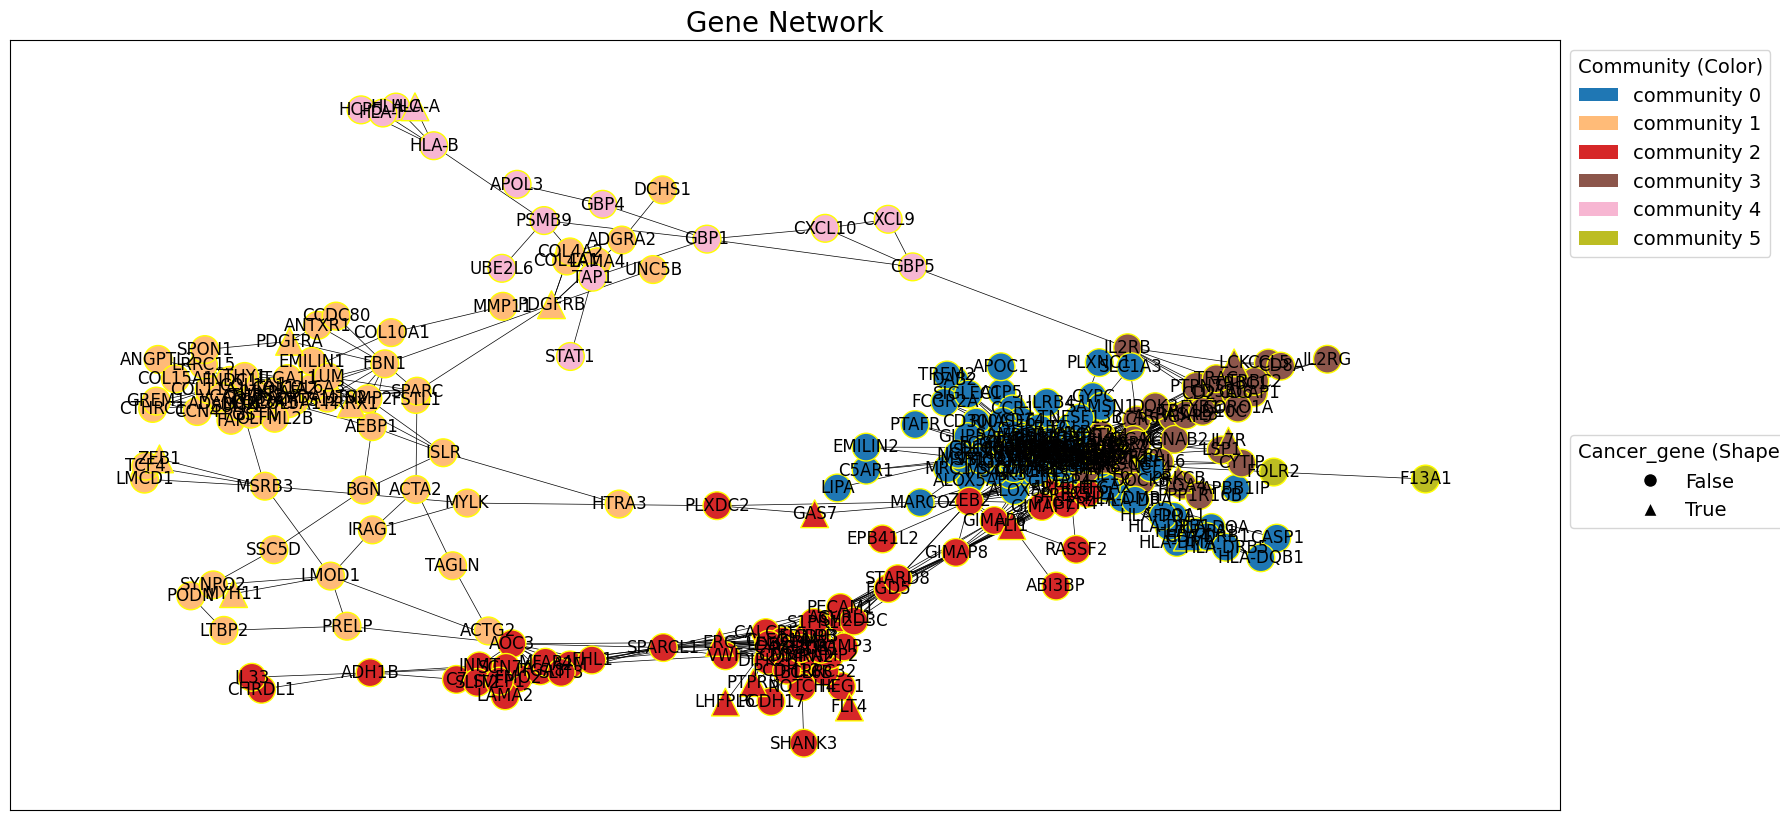

In [12]:
# Visualize the gene correlation network with community memberships
### YOUR CODE HERE ###
draw_network_with_node_attrs(G_gxp, title='Gene Network', node_attributes=node_attributes, communities=communities, color_attr='community', shape_attr='cancer_gene', with_labels=True)

#### Perform ORA on Each Community

- Perform ORA on Each Community: Performing ORA on individual clusters can help in understanding distinct biological significance of each cluster, revealing how certain pathways or functions are associated with specific subsets of genes and potentially uncovering biological themes that may be missed.

In [13]:
communities

[frozenset({'ACP5',
            'AIF1',
            'ALOX5',
            'ALOX5AP',
            'APBB1IP',
            'APOC1',
            'BTK',
            'C1QA',
            'C1QB',
            'C1QC',
            'C1orf162',
            'C3AR1',
            'C5AR1',
            'CASP1',
            'CCR1',
            'CD14',
            'CD163',
            'CD300A',
            'CD4',
            'CD52',
            'CD53',
            'CD74',
            'CD84',
            'CD86',
            'CMKLR1',
            'CSF1R',
            'CYBB',
            'DAB2',
            'DOK2',
            'EMILIN2',
            'FCER1G',
            'FCGR2A',
            'FCGR3A',
            'FERMT3',
            'FGL2',
            'FGR',
            'FPR1',
            'FPR3',
            'GLIPR2',
            'GMFG',
            'GYPC',
            'HAVCR2',
            'HCK',
            'HK3',
            'HLA-DMA',
            'HLA-DMB',
            'HLA-DOA',
            'HLA-DPA

In [14]:
# Function to perform ORA on a given list of genes
def communityORA(genes):
    enr = gp.enrichr(gene_list=genes, gene_sets=[gene_sets], organism='human', outdir=None)
    return enr

# Convert communities to lists for ORA
### YOUR CODE HERE ###
communities = [list(community) for community in communities]
communities = sorted(communities, key=len, reverse=True)

# Perform ORA for three selected communities
### YOUR CODE HERE ###
community1_enr = communityORA(communities[0])
community2_enr = communityORA(communities[1])
community3_enr = communityORA(communities[2])

# Print the top 10 results for each community
x = PrettyTable()
x.field_names = ["Community 1", "Community 2", "Community 3"]
for i in range(10):
    x.add_row([community1_enr.results['Term'][i], community2_enr.results['Term'][i], community3_enr.results['Term'][i]])
print(x)


+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|                 Community 1                  |                     Community 2                      |                   Community 3                   |
+----------------------------------------------+------------------------------------------------------+-------------------------------------------------+
|       Staphylococcus aureus infection        |           Protein digestion and absorption           |             Cell adhesion molecules             |
|                  Phagosome                   |                    Focal adhesion                    |       Complement and coagulation cascades       |
|                Leishmaniasis                 |               ECM-receptor interaction               |             ECM-receptor interaction            |
|                 Tuberculosis                 |              Relaxin signal

#### 1.2 Gene Set Enrichment Analysis (GSEA)

Gene Set Enrichment Analysis (GSEA) is a genome-wide expression analysis method designed to interpret expression profiles focusing on pre-defined gene sets. These gene sets are curated based on prior biological knowledge, such as published information about biochemical pathways or patterns of coexpression observed in previous experiment studies. The genes can be ordered in a ranked list, according to their differential expression between the classes. The primary objective of GSEA is to assess whether the genes within a given gene set tend to occur toward the top (or bottom) of the ranked list. This ranking is based on the correlation between gene expression and a particular phenotypic class distinction. By evaluating the distribution of gene set members within the ranked list, GSEA identifies whether the set is correlated with the phenotypic class, thus providing insights into underlying biological mechanisms. This method contrasts with traditional single-gene analysis by focusing on the collective behavior of gene sets, thereby uncovering biologically significant patterns that might be overlooked when examining individual genes in isolation. We use `gseapy` to perform GSEA on `KEGG_2021_Human` assigned classes based on a phenotypic attribute (e.g., smoking status). (ref)

<!-- (https://pnnl-comp-mass-spec.github.io/proteomics-data-analysis-tutorial/gsea.html) for referencing.  -->


In [15]:
# Display the first five rows of the dataframe "tcga_gxp_df"
### YOUR CODE HERE ###
print(tcga_gxp_df.head(5))

        TCGA-38-7271  TCGA-55-7914  TCGA-95-7043  TCGA-73-4658  TCGA-86-8076  \
GENES                                                                          
TSPAN6       11.3668       11.5434       11.4110       12.2149       11.2882   
DPM1         10.3673       10.5282       11.2018       10.3249       10.2095   
SCYL3         9.7884        9.7292        9.4449        9.2340        9.8186   
FIRRM         8.2552        7.9951        8.3546        7.7537        7.9844   
FGR          10.6173        8.4858        7.3211       11.0656       10.5213   

        TCGA-55-7726  TCGA-44-6147  TCGA-50-5932  TCGA-44-2661  TCGA-86-7954  \
GENES                                                                          
TSPAN6       11.2084       11.1717       12.1281       11.9908       12.2601   
DPM1         11.6034       10.5684       10.5895       10.8699       10.8979   
SCYL3         9.0884       10.2428       10.1989        9.8516        9.7973   
FIRRM         8.7984        8.8721     

#### Assign classes based on phenotypic attributes in metadata (e.g., smoking status)

In [16]:
# Create a dictionary to store the class assignments for each sample
classes = {}

# Iterate through the columns (samples)
for sample in tcga_gxp_df.loc[G_gxp_nodes_list].columns: # ".loc[G_gxp_nodes_list]" grabs rows of specified gene symbols
    # Assign class labels based on the smoking status from the metadata
    if tcga_gxp_meta.loc[sample, 'Smoked'] == 'Smoker': ### YOUR CODE HERE ###
        classes[sample] = 'smoker' 
    elif tcga_gxp_meta.loc[sample, 'Smoked'] == 'Never':
        classes[sample] = 'control'
    else:
        pass


In [17]:
# Perform GSEA using the prepared data and class assignments
gs_res = gp.gsea(data=tcga_gxp_df.loc[G_gxp_nodes_list], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7)

# Display the top results from the GSEA
### YOUR CODE HERE ###
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Toxoplasmosis,0.672196,1.87385,0.017544,0.131839,0.05,11/19,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA
1,gsea,Influenza A,0.708245,1.7236,0.117647,0.477917,0.11,11/17,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
2,gsea,Th1 and Th2 cell differentiation,0.735164,1.659187,0.096154,0.399637,0.18,10/16,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
3,gsea,Th17 cell differentiation,0.735164,1.659187,0.096154,0.399637,0.18,10/16,14.33%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
4,gsea,Human T-cell leukemia virus 1 infection,0.645243,1.649653,0.083333,0.323006,0.18,13/22,18.67%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F


#### Visualising GSEA Results

Once you have performed GSEA, the next step is to visualise the results. Visualisation helps in interpreting the biological significance of the enriched gene sets. Here, we visualise GSEA results with Barcode Enrichment Plot, Heatmap, Clustermap, and Dot Plot. 

### Barcode Enrichment Plot

Barcode Enrichment Plot shows the positions of members of a given gene set in a ranked list of enrichment scores for the top enriched terms. The scores are ranked left to right from smallest to largest. The ranked scores are represented by a shaded bar, forming a pattern like a barcode. 

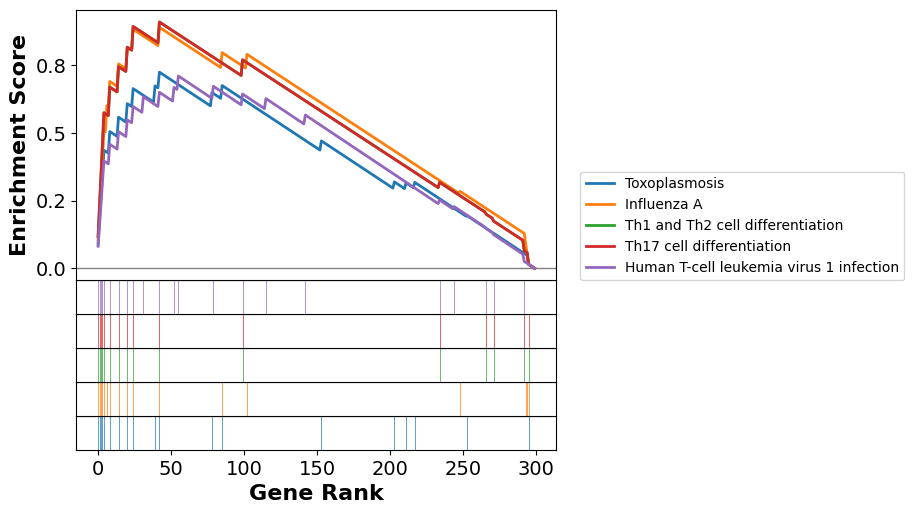

In [18]:
# Extract the enriched terms from the GSEA results. The terms represent pathways or functional categories that are significantly enriched in the dataset.
terms = gs_res.res2d.Term

# Plot the top 5 enriched terms
# The plot function visualizes the enrichment results
axs = gs_res.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})

You can view and extract leading-edge genes from GSEA results. Leading-edge genes are the subset of genes that contribute most to the enrichment score.

In [19]:
# View leading-edge genes from the GSEA results. 
gs_res.res2d.Lead_genes

0                                                          HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;ALOX5;HLA-DOA
1                                                          HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
2                                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
3                                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA
4                                               HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5;SPI1;HLA-DOA;ITGB2;HLA-F
5                                                HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;HLA-DOA;ITGB2
6         HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-D

### Heatmap Visualisation

`gseapy` provides a heatmap function to visualise the expression levels of the leading-edge genes. The heatmap provides a visual representation of how these genes are expressed across different samples in relation to their assigned phenotypic classes. 

[]

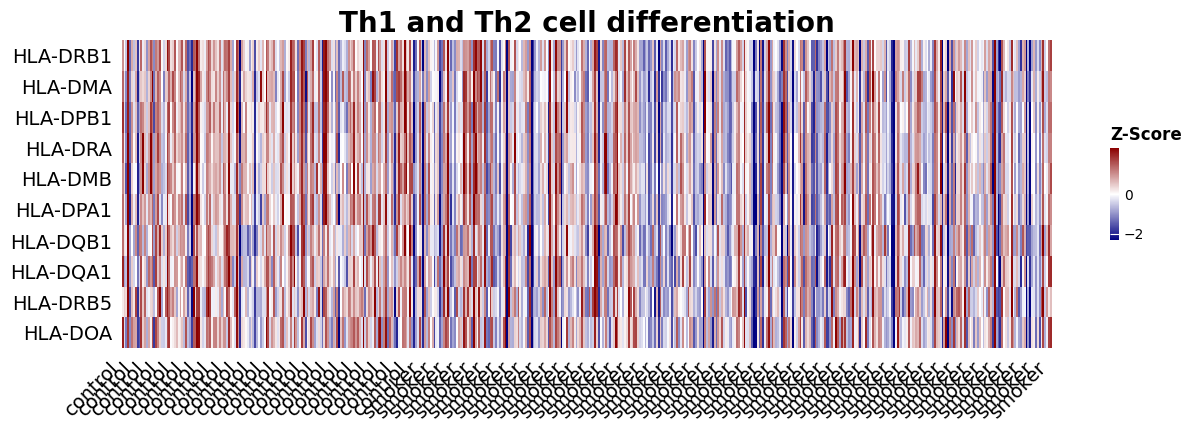

In [20]:
# Import the heatmap function from gseapy
from gseapy import heatmap

# Select the index of the term to visualize
i = 2

# Extract the genes contributing to the enrichment of the selected term
genes = gs_res.res2d.Lead_genes[i].split(";")

# Generate a heatmap of the expression levels of the leading-edge genes
ax = heatmap(df=gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(15, 4))

# Update the x-tick labels with the class labels
xtick_labels = [classes[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.plot()

### Clustermap Visualisation

The function `clustermap` from `seaborn` is used to create a clustered heatmap. It not only shows the expression levels of the leading-edge genes but also clusters them based on similarity, providing additional insights into gene expression patterns. The cluster map includes dendrograms, which show the hierarchical clustering of both genes and samples, helping to identify groups of co-expressed genes and similar samples.

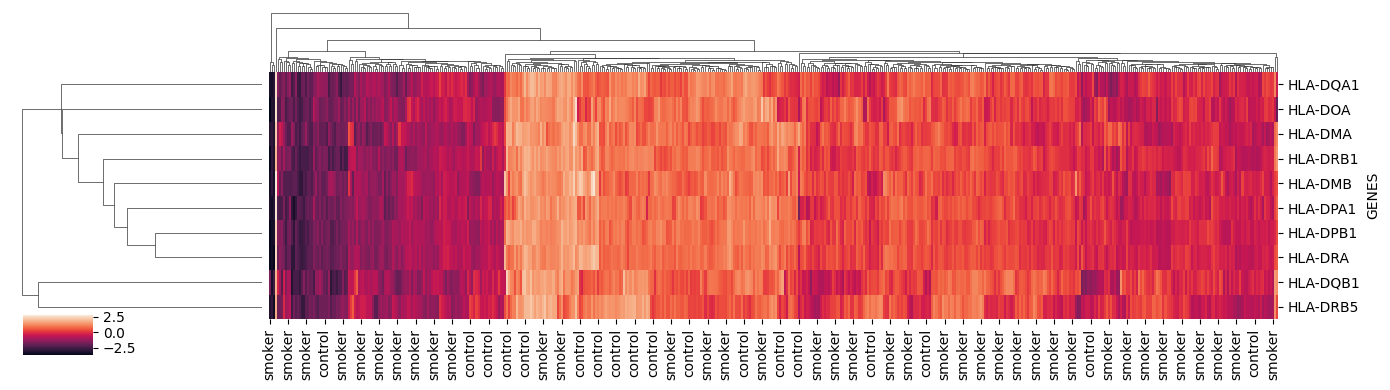

In [21]:

# Import the clustermap function from seaborn
from seaborn import clustermap

# Select the index of the term to visualize
i = 2

# Extract the genes contributing to the enrichment of the selected term
genes = gs_res.res2d.Lead_genes[i].split(";")

# Extract the relevant subset of the heatmap data
data = gs_res.heatmat.loc[genes]

# Rename the columns based on the class assignments
data.rename(columns=classes, inplace=True)

# Generate a cluster map of the expression levels of the leading-edge genes
ax = clustermap(
    data=data,  # The data to cluster
    method='average',  # Clustering method
    metric='euclidean',  # Distance metric
    z_score=0,  # Standardize the data
    figsize=(14, 4),  # Size of the figure
    dendrogram_ratio=0.2,  # Ratio of the dendrogram
    colors_ratio=0.03,  # Ratio of the colors
    cbar_pos=(0.02, 0.1, 0.05, 0.1)  # Position of the color bar
)

### Dot Plot Visualisation

Use the `dotplot` function in `gseapy` to create a visual representation of the GSEA results. Here we use "FDR q-val" to determine the dot sizes, which represents the false discovery rate adjusted p-values. We display normalised enrichment score (NES) value as the x-axis. 

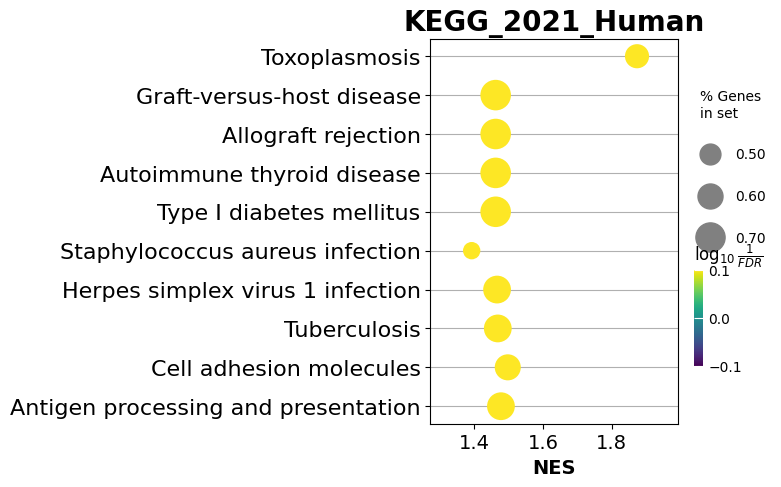

In [22]:
# Import the dotplot function from gseapy
from gseapy import dotplot

# Generate the dot plot for the GSEA results
# The dotplot function visualizes the enrichment results, focusing on the FDR q-values
ax = dotplot(gs_res.res2d,
             column="FDR q-val",  # Column to be used for dot size
             title='KEGG_2021_Human',  # Title of the plot
             cmap=plt.cm.viridis,  # Color map for the dots
             size=5,  # Size of the dots
             figsize=(4, 5),  # Size of the figure
             cutoff=1)  # Cutoff for displaying the terms

### GSEA on Clusters

Similarly to ORA, GSEA can also be performed on individual communities after clustering. This allows for a more granular analysis, revealing pathways and functions that are enriched within particular subgroups of the data.


In [23]:
# Define a function to perform GSEA on a given list of genes (community)
def communityGSEA(genes, gene_sets='KEGG_2021_Human', classes=classes):
    gs_res = gp.gsea(data=tcga_gxp_df.loc[genes], gene_sets=gene_sets, cls=classes, permutation_num=100, outdir=None, method='signal_to_noise', threads=4, seed=7, min_size=1) 
    return gs_res

# Perform GSEA for three community
community1_gsea = communityGSEA(communities[0])
community2_gsea = communityGSEA(communities[1]) 
community3_gsea = communityGSEA(communities[2])


In [24]:
# Display the top results for the first community
community1_gsea.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Epstein-Barr virus infection,0.853817,1.789511,0.0,0.324881,0.14,10/11,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;HLA-DQA1;BTK;HLA-DRB5
1,gsea,Leishmaniasis,0.667361,1.767749,0.040816,0.181183,0.17,11/18,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5
2,gsea,Influenza A,0.805713,1.723862,0.0,0.191596,0.2,10/12,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;CASP1;HLA-DPA1;HLA-DQB1;HLA-DQA1;HLA-DRB5
3,gsea,Phagosome,0.595196,1.717777,0.041667,0.149945,0.21,16/22,34.65%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;NCF4;NCF2;HLA-DQB1;HLA-DQA1;HLA-DRB5;MSR1;HLA-DOA;MARCO;ITGB2;MRC1
4,gsea,Cell adhesion molecules,0.649813,1.710744,0.04,0.127453,0.22,10/16,16.83%,HLA-DRB1;HLA-DMA;HLA-DPB1;HLA-DRA;HLA-DMB;HLA-DPA1;HLA-DQB1;SELPLG;HLA-DQA1;HLA-DRB5


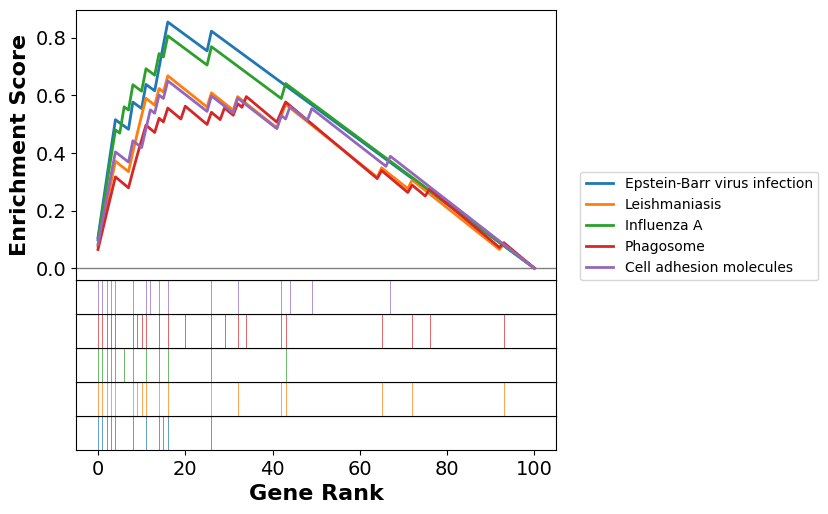

In [25]:
# Extract the enriched terms from the GSEA results for the first community
terms = community1_gsea.res2d.Term

# Plot the top 5 enriched terms for the first community
axs = community1_gsea.plot(terms[:5], show_ranking=False, legend_kws={'loc': (1.05, 0)})